### Dataset preparation    
1. convert glacier vector to glacier image. 
2. split dataset into traset and valset. 

In [ ]:
import glob
import numpy as np
import rasterio as rio 
import cartopy.crs as ccrs
import geopandas as gpd
from rasterio import features
import matplotlib.pyplot as plt
from utils.imgShow import imgShow
import cartopy.feature as cfeature 


In [2]:
### get the secene and truth pairwise data
paths_truth = sorted(glob.glob('data/dset/truth/*.gpkg'))
paths_scene = [path.replace('.gpkg', '.tif').replace('truth','scene') for path in paths_truth]
paths_dem = [path.replace('.tif', '_dem.tif').replace('truth','dem') 
                    for path in paths_truth]
print(len(paths_scene))
print(len(paths_truth))


65
65


#### 1. convert glacier vector to raster files.  

In [3]:
## check the scene images and the truth vector
id_dset = 57
scene_rio = rio.open(paths_scene[id_dset])
truth_vec_gpd = gpd.read_file(paths_truth[id_dset])
scene_extent = [scene_rio.bounds.left, scene_rio.bounds.right, scene_rio.bounds.bottom, scene_rio.bounds.top]
print(paths_scene[id_dset], paths_truth[id_dset])


data/dset/scene/s2_scene_06.tif data/dset/truth/s2_scene_06.gpkg


(6320000.0, 6330000.0)

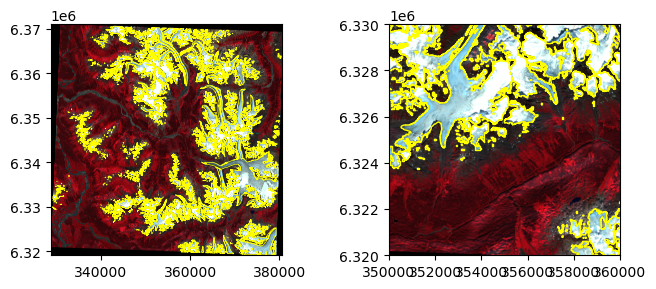

In [4]:
if scene_rio.crs != truth_vec_gpd.crs:
    print('crs transformation needed')
    truth_vec_gpd = truth_vec_gpd.to_crs(scene_rio.crs.to_dict())
## show the scene and the truth vector
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
## ax[0]
imgShow(scene_rio.read([2,3,4]).transpose(1,2,0), 
            ax=ax[0], clip_percent=5, extent=scene_extent)
truth_vec_gpd.plot(ax=ax[0], color='none', 
                   edgecolor='yellow', linewidth=0.5) 
## ax[1]
imgShow(scene_rio.read([2,3,4]).transpose(1,2,0), 
            ax=ax[1], clip_percent=5, extent=scene_extent)
truth_vec_gpd.plot(ax=ax[1], color='none', 
                   edgecolor='yellow', linewidth=1) 
ax[1].set_xlim([350000, 360000])
ax[1].set_ylim([6320000, 6330000])


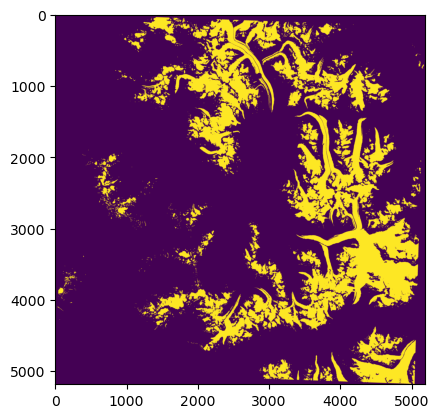

In [6]:
###  create a mask from the truth vector
def create_mask_from_vec(img_rio, vec_gpd):
    if vec_gpd.crs != img_rio.crs:
        vec_gpd = vec_gpd.to_crs(img_rio.crs.to_dict())
    shapes = [(geom, 1) for geom in vec_gpd.geometry if geom is not None and not geom.is_empty]

    mask_water = features.rasterize(
        shapes=shapes,
        out_shape=(img_rio.height, img_rio.width),
        transform=img_rio.transform,
        all_touched=False,
        default_value=1,
        fill=0,
        dtype=np.uint8)
    return mask_water

mask_water = create_mask_from_vec(img_rio = scene_rio, vec_gpd=truth_vec_gpd)
plt.imshow(mask_water) 


In [8]:
## write the mask to a geotiff
path_truth_gpkg = paths_truth[id_dset]
path_truth_img = path_truth_gpkg.replace('.gpkg', '.tif')

def write_mask_to_geotiff(mask, scene_rio, path_save):
    mask_meta = scene_rio.meta.copy()
    mask_meta.update({
        'dtype': 'uint8',
        'count': 1,
        'compress': 'lzw',
        'nodata': 0
    })    
    with rio.open(path_save, 'w', **mask_meta) as dst:
        dst.write(mask, 1)
    print('mask written to', path_save)

write_mask_to_geotiff(mask = mask_water, scene_rio=scene_rio, path_save = path_truth_img)


mask written to data/dset/truth/s2_scene_06.tif


In [ ]:
## batch processing: convert the .gpkg vector to .tiff truth image.
for i, path_truth_vec in enumerate(paths_truth):
    truth_vec_gpd = gpd.read_file(path_truth_vec)
    scene_rio = rio.open(paths_scene[i])
    ### generate water mask
    if scene_rio.crs != truth_vec_gpd.crs:
        truth_vec_gpd = truth_vec_gpd.to_crs(scene_rio.crs.to_dict())
    mask_water = create_mask_from_vec(img_rio = scene_rio, 
                                        vec_gpd=truth_vec_gpd)
    ### write the water mask to a geotiff
    path_truth_img = path_truth_vec.replace('.gpkg', '.tif')
    write_mask_to_geotiff(mask = mask_water, scene_rio=scene_rio, 
                                        path_save = path_truth_img)
    scene_rio.close()
    break 


mask written to data/dset/truth/l5_scene_01.tif


#### 2. split dataset into traset and valset

In [ ]:
def tra_val_split(paths_dset):
    ''' 
    split the dataset into training and validation sets (traset:valset = 3:1)
    '''
    num_dset = len(paths_dset)
    ids_dset = list(range(num_dset))
    ids_val = ids_dset[::4]  ## every 4th scene for validation
    ids_tra = list(set(ids_dset) - set(ids_val))  ## remaining scenes for training
    return ids_tra, ids_val
ids_tra, ids_val = tra_val_split(paths_truth)
## get the paths for training and validation sets
paths_truth_tra = [paths_truth[i] for i in ids_tra]
paths_scene_tra = [paths_scene[i] for i in ids_tra]
paths_dem_tra = [paths_dem[i] for i in ids_tra]
paths_truth_val = [paths_truth[i] for i in ids_val]
paths_scene_val = [paths_scene[i] for i in ids_val]
paths_dem_val = [paths_dem[i] for i in ids_val]
print(f'train data: {len(paths_scene_tra)}, vali data: {len(paths_scene_val)}')
print('train scene ids:', ids_tra)  
print('vali scene ids:', ids_val)  


train data: 48, vali data: 17
train scene ids: [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 26, 27, 29, 30, 31, 33, 34, 35, 37, 38, 39, 41, 42, 43, 45, 46, 47, 49, 50, 51, 53, 54, 55, 57, 58, 59, 61, 62, 63]
vali scene ids: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]


In [59]:
centers_tra, centers_val = [], []
for id_tra in ids_tra:
    truth_gdf = gpd.read_file(paths_truth[id_tra])
    center = truth_gdf.to_crs(epsg=4326).union_all().centroid
    centers_tra.append(center)
for id_val in ids_val:
    truth_gdf = gpd.read_file(paths_truth[id_val])
    center = truth_gdf.to_crs(epsg=4326).union_all().centroid
    centers_val.append(center)
centers_tra_gs = gpd.GeoSeries(centers_tra)
centers_val_gs = gpd.GeoSeries(centers_val) 

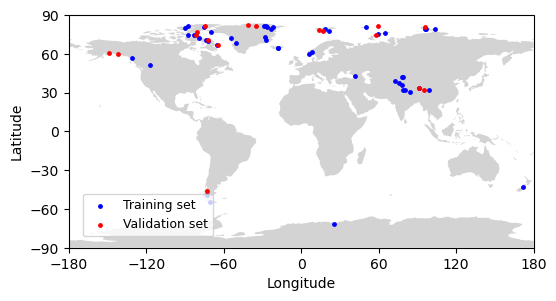

In [ ]:

fig, ax = plt.subplots(figsize=(6, 4), 
                subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, -90, 90])
centers_tra_gs.plot(ax=ax, marker='o', 
                    markersize=6, 
                    color='blue', 
                    label='Training set',
                    )
centers_val_gs.plot(ax=ax, marker='o', 
                    markersize=6, 
                    color='red', 
                    label='Validation set',
                    )
ax.legend(loc=(0.03,0.05), fontsize=9)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)
# fig.savefig('figs/traset_valset.png', dpi=300)

